In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# 新段落

In [ ]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float64)
torch.manual_seed(13)



# Sampling parameters etc
#n_axis = 51
n_axis = 41
#n_time = 131
n_time = 61

axis = torch.linspace(-2,2,n_axis, device=device)
time = torch.linspace(0,12,n_time, device=device)
Ps = torch.cartesian_prod(axis,axis,time)
# Number of points
lP = Ps.shape[0]


# Initial dataset
data_axis = torch.linspace(-2,2, 81, device=device)
data_time = torch.linspace(0,12,121, device=device)
data_Ps = torch.cartesian_prod(data_axis,data_axis,data_time)
#data_Ps = torch.cartesian_prod(axis,axis,time)

mask = (data_Ps[:,2] == 0.) * (((data_Ps[:,0])*(data_Ps[:,0])+(data_Ps[:,1])*(data_Ps[:,1]) - 4.) < 0.1)
X = data_Ps[mask]
dtX = data_Ps[mask]

mask1 = (abs((data_Ps[:,0])*(data_Ps[:,0])+(data_Ps[:,1])*(data_Ps[:,1]) - 4.) < 0.1)
dxX = data_Ps[mask1]

#mask2 = (abs(abs(data_Ps[:,1]) - 2.) < 1e-10)
#dyX = data_Ps[mask2]

Y = torch.exp(-((X[:,0])**2+(X[:,1])**2)*10)
#Y = torch.exp(-(X[:,0])**2*5)+torch.exp(-(X[:,1])**2*5)
#Y = torch.cos((X[:,0]-1)*5)+torch.cos((X[:,1]-1)*5)
Y = Y.view(-1,1)

dtY = -2*5*(X[:,0])*torch.exp(-(X[:,0])**2*5)+2*5*(X[:,0])*torch.exp(-(X[:,0])**2*5)
#dtY = -2*5*(X[:,0])*torch.exp(-(X[:,0])**2*5)-2*5*(X[:,1])*torch.exp(-(X[:,1])**2*5)
#dtY = -5*(torch.sin((X[:,0]-1)*5)+torch.sin((X[:,1]-1)*5))
dtY = dtY.view(-1,1)

dxY = torch.where( ((dxX[:,0]-1).abs() < 1e-1) & (dxX[:,1].abs() < 1), 0., 0. )
dxY = dxY.view(-1,1)

#dyY = torch.where( ((dyX[:,0]-1).abs() < 1e-1) & (dyX[:,1].abs() < 1), 0., 0. )
#dyY = dyY.view(-1,1)

X = torch.cat((X,dxX),0)
Y = torch.cat((Y,dxY),0)

dtX = dtX.to(torch.complex128)
#dyX = dyX.to(torch.complex128)
dtY = dtY.to(torch.complex128)
#dyY = dyY.to(torch.complex128)
X = X.to(torch.complex128)
Y = Y.to(torch.complex128)
#Y = torch.cat((Y,dtY,dxY,dyY),0)
Y = torch.cat((Y,dtY),0)

Using cuda device


In [ ]:
def getVarietyPoints(base1,base2):
    x1,y1 = base1.unbind(1)
    x2,y2 = base2.unbind(1)
    t1 = torch.sqrt(x1.square() + y1.square())
    t2 = torch.sqrt(x2.square() + y2.square())

    return torch.stack([ torch.stack([x1,y1,t1],1), torch.stack([x2,y2,-t2],1) ])

def Phi(base1, base2, X):
    pts = getVarietyPoints(base1, base2)
    # return (pts.inner(X) * 1.j).exp().mean(0)
    return (pts.inner(X)).exp().mean(0)

def dtPhi(base1, base2, X):
    pts = getVarietyPoints(base1, base2)
    return ((pts.inner(X)).exp().mul(pts[:,:,2].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))

def dxPhi(base1, base2, X):
    pts = getVarietyPoints(base1, base2)
    return ((pts.inner(X)).exp().mul(pts[:,:,0].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))

def dyPhi(base1, base2, X):
    pts = getVarietyPoints(base1, base2)
    return ((pts.inner(X)).exp().mul(pts[:,:,1].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))


def train(N):
    for epoch in range(N):
        PhiX = Phi(MC_base1 * 1.j, MC_base2 * 1.j, X)
        dtPhiX = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, dtX)
        #dyPhiX = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, dyX)
        #PhiX = torch.cat((PhiX,dtPhiX,dxPhiX,dyPhiX),1)
        PhiX = torch.cat((PhiX,dtPhiX),1)
        A = torch.diag_embed((eps - S_diag).exp()) + PhiX @ PhiX.H
        LA = torch.linalg.cholesky(A)
        alpha = torch.linalg.solve_triangular(LA, PhiX @ Y.to(torch.complex128), upper=False)

        nlml = 1/(2*eps.exp()) * (Y.norm().square() - alpha.norm().square())
        nlml += (PhiX.shape[1] - PhiX.shape[0])/2 * eps
        nlml += LA.diag().real.log().sum()
        nlml += 0.5*S_diag.sum()

        opt.zero_grad()
        nlml.backward()
        opt.step()

        with torch.no_grad():
            train_pred = PhiX.H @ torch.linalg.solve_triangular(LA.H, alpha, upper=True)
            err = (train_pred.real - Y).square().mean().sqrt()
            print(26*"~" + f'\nepoch {epoch}\n\
nlml {nlml}\n\
err {err}\n\
eps {eps.exp()}\n\
base1 std {MC_base1.std(0)}\n\
base2 std {MC_base2.std(0)}\n\
min,max {train_pred.real.min().detach(),train_pred.real.max().detach()}')

In [ ]:
n_MC = 1000
# MC_axis = torch.linspace(-1,1, n_MC, device=device) * 30
MC_base1 = (torch.randn((n_MC, 2), device=device)).requires_grad_()
MC_base2 = (torch.randn((n_MC, 2), device=device)).requires_grad_()
# MC_base = torch.cartesian_prod(MC_axis,MC_axis).requires_grad_()
S_diag = torch.full((n_MC,), -np.log(n_MC), requires_grad=False, device=device)
# S_diag = torch.full((n_MC**2,), -np.log(n_MC**2), requires_grad=False, device=device)
eps = torch.tensor(np.log(1e-2), requires_grad=True, device=device)

In [ ]:
opt = torch.optim.Adam([
    {'params': [MC_base1, MC_base2], 'lr': 1e-1},
    {'params': eps, 'lr': 1e-2}])
#train(100000)
train(10000)
opt = torch.optim.Adam([
    {'params': [MC_base1, MC_base2], 'lr': 1e-1},
    {'params': eps, 'lr': 1e-2}])
#train(100000)
train(10000)
opt = torch.optim.Adam([
    {'params': [MC_base1, MC_base2], 'lr': 1e-2},
    {'params': [S_diag, eps], 'lr': 1e-2}])
train(1000)
opt = torch.optim.Adam([
    {'params': [MC_base1, MC_base2], 'lr': 1e-3},
    {'params': [S_diag, eps], 'lr': 1e-3}])
train(300)
torch.save({
            'MC_base1': MC_base1.cpu(),
            'MC_base2': MC_base2.cpu(),
            'S_diag': S_diag.cpu(),
            'eps': eps.cpu(),
    }, "state.pt")


流式输出内容被截断，只能显示最后 5000 行内容。
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 675
nlml -202714.2369954289
err (0.004172060201546194-2.564884691787622e-19j)
eps 1.7911012102940623e-05
base1 std tensor([6.6704, 6.7423], device='cuda:0')
base2 std tensor([6.7127, 6.6944], device='cuda:0')
min,max (tensor(-0.0266, device='cuda:0'), tensor(0.9670, device='cuda:0'))
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 676
nlml -202702.89437893496
err (0.004172679037671829-2.5792861430983727e-19j)
eps 1.7909866090642385e-05
base1 std tensor([6.6704, 6.7422], device='cuda:0')
base2 std tensor([6.7127, 6.6944], device='cuda:0')
min,max (tensor(-0.0265, device='cuda:0'), tensor(0.9669, device='cuda:0'))
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 677
nlml -202676.79060238073
err (0.0041740245099696925-2.5700611258355483e-19j)
eps 1.7909569466063034e-05
base1 std tensor([6.6704, 6.7422], device='cuda:0')
base2 std tensor([6.7127, 6.6944], device='cuda:0')
min,max (tensor(-0.0269, device='cuda:0'), tensor(0.9670, device='cuda:0'))
~~~~~~~~~~~~~~

In [ ]:
#torch.save({
#            'MC_base1': MC_base1.cpu(),
#            'MC_base2': MC_base2.cpu(),
#            'S_diag': S_diag.cpu(),
#            'eps': eps.cpu(),
#    }, "state.pt")


st = torch.load("state.pt")
MC_base1 = st['MC_base1']
MC_base2 = st['MC_base2']
S_diag = st['S_diag']
eps = st['eps']

# Prediction
#Phi_ = Phi(MC_base * 1.j, Ps.to(torch.complex128)).to(device)
Phi_ = Phi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
dtPhi_ = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#dyPhi_ = dyPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#Phi_ = torch.cat((Phi_,dtPhi_,dxPhi_,dyPhi_),1)
Phi_ = torch.cat((Phi_,dtPhi_),1)
PhiX = Phi(MC_base1 * 1.j, MC_base2 * 1.j, X.to("cpu"))
dtPhiX = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, dtX.to("cpu"))
#dyPhiX = dyPhi(MC_base1 * 1.j, MC_base2 * 1.j, dyX.to("cpu"))
#PhiX = torch.cat((PhiX,dtPhiX,dxPhiX,dyPhiX),1)
PhiX = torch.cat((PhiX,dtPhiX),1)
A = torch.diag_embed((eps - S_diag).exp()) + PhiX @ PhiX.H
LA = torch.linalg.cholesky(A)
alpha = torch.linalg.solve_triangular(LA, PhiX @ Y.to("cpu").to(torch.complex128), upper=False)
pred = Phi_.H @ torch.linalg.solve_triangular(LA.H, alpha.to("cpu"), upper=True)
pred = pred.real

pred.detach().cpu().numpy().tofile("pred.dat")
axis.cpu().numpy().tofile("axis.dat")
time.cpu().numpy().tofile("time.dat")

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!cp pred.dat "/content/drive/MyDrive/Colab Notebooks"
!cp axis.dat "/content/drive/MyDrive/Colab Notebooks"
!cp time.dat "/content/drive/MyDrive/Colab Notebooks"
!cp state.pt "/content/drive/MyDrive/Colab Notebooks"

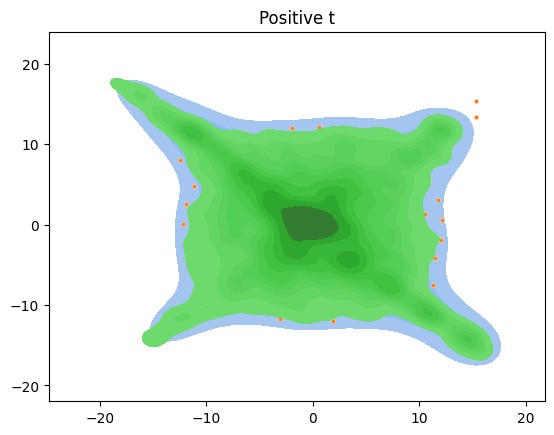

In [ ]:
plt.ion()
f, ax = plt.subplots()
sn.kdeplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], fill=True)
sn.scatterplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], s=10)
sn.kdeplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], bw_adjust=0.5, fill=True)
plt.title("Positive t")
plt.show()

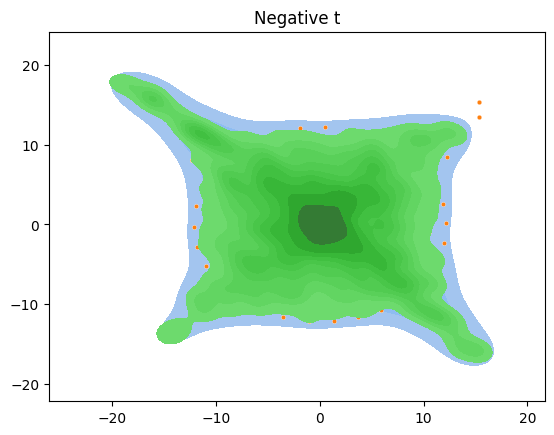

In [ ]:
plt.ion()
f, ax = plt.subplots()
sn.kdeplot(x = MC_base2.detach().numpy()[:,0], y = MC_base2.detach().numpy()[:,1], fill=True)
sn.scatterplot(x = MC_base2.detach().numpy()[:,0], y = MC_base2.detach().numpy()[:,1], s=10)
sn.kdeplot(x = MC_base2.detach().numpy()[:,0], y = MC_base2.detach().numpy()[:,1], bw_adjust=0.5, fill=True)
plt.title("Negative t")
plt.show()